#TASK 01: Repeat all the task from worksheet - 5 but, try to improve the model from last week with same dataset.
• Use Data Augmentation to increase the number of training image.

• Use deeper model with BN and DropOut layer as presented above.

• Understand the Model Summary and Training Behavior.

• Use Data Augmentation to increase the number of training image.

• Use deeper model with BN and DropOut layer as presented above.

• Understand the Model Summary and Training Behavior.

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding and Visualization



In [ ]:
train_folder = "/content/drive/MyDrive/Content/FruitinAmazon/train"
test_folder = "/content/drive/MyDrive/Content/FruitinAmazon/test"

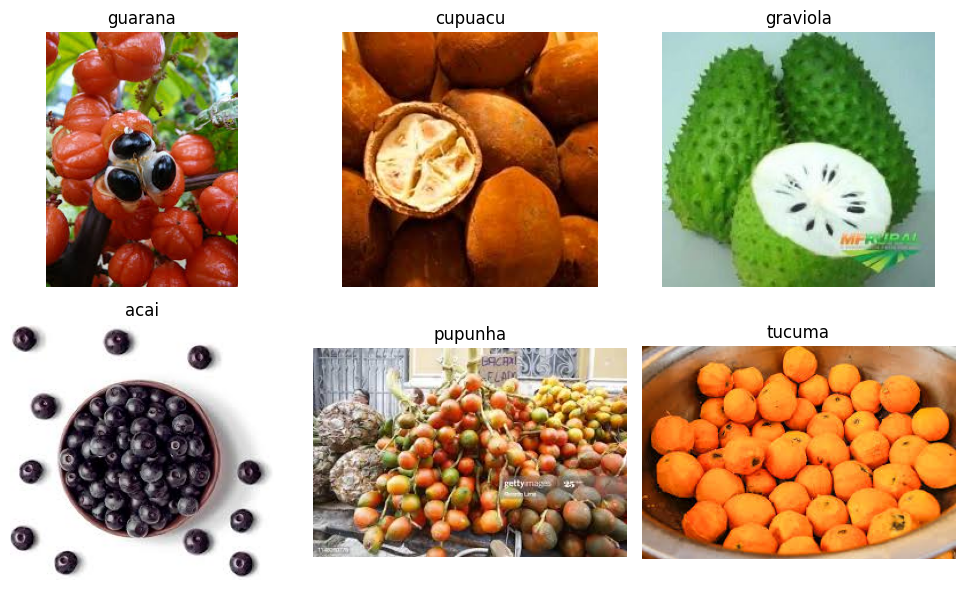

In [ ]:
# Get the list of class directories
class_names = [d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))]

# Select one random image from each class
selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_folder, class_name)
    images = os.listdir(class_path)

    # Randomly select one image
    if images:
        selected_image = random.choice(images)
        selected_images.append((class_name, os.path.join(class_path, selected_image)))

# Display images in a grid with two rows
num_classes = len(selected_images)
cols = (num_classes + 1) // 2  # Number of columns in the grid

fig, axes = plt.subplots(2, cols, figsize=(10, 6))
axes = axes.flatten()  # Flatten for easy indexing

for i, (class_name, image_path) in enumerate(selected_images):
    img = mpimg.imread(image_path)  # Load image
    axes[i].imshow(img)  # Show image
    axes[i].set_title(class_name)  # Set title
    axes[i].axis("off")  # Hide axes

# Hide unused axes if any
for i in range(len(selected_images), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

**What did you observe?**

Since the selection is random, running the script multiple times gives different images each time.

The script randomly picks one class folder from the dataset.Then, it randomly selects one image from that class.The image file name and path are printed.

2. Check for Corrupted Image: Write a script that verifies whether the image in the train
directory are valid. If any corrupted images are found, the script must remove the image from
the directory and print the message which image have been removed, if none found print ”No
Corrupted Images Found.”

In [ ]:
# List to keep track of corrupted images
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_name)

    if os.path.isdir(class_path):  # Ensure it's a directory
        # Iterate through each image file in the class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Try opening the image
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image is valid
            except (IOError, SyntaxError):
                # If an error occurs, it means the image is corrupted
                corrupted_images.append(image_path)
                os.remove(image_path)  # Remove the corrupted image
                print(f"Removed corrupted image: {image_path}")

# Check if any corrupted images were found
if not corrupted_images:
    print("No corrupted images found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")


No corrupted images found.


# Loading and Preprocessing Image Data in keras


In [ ]:
# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
     train_folder, labels='inferred',
     label_mode='int',
     image_size=(img_height, img_width),
     interpolation='nearest',
     batch_size= batch_size,
     shuffle=True,
     validation_split=validation_split,
     subset='training',
     seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [ ]:

# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation
# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]
# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)
# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


#Data augmentation


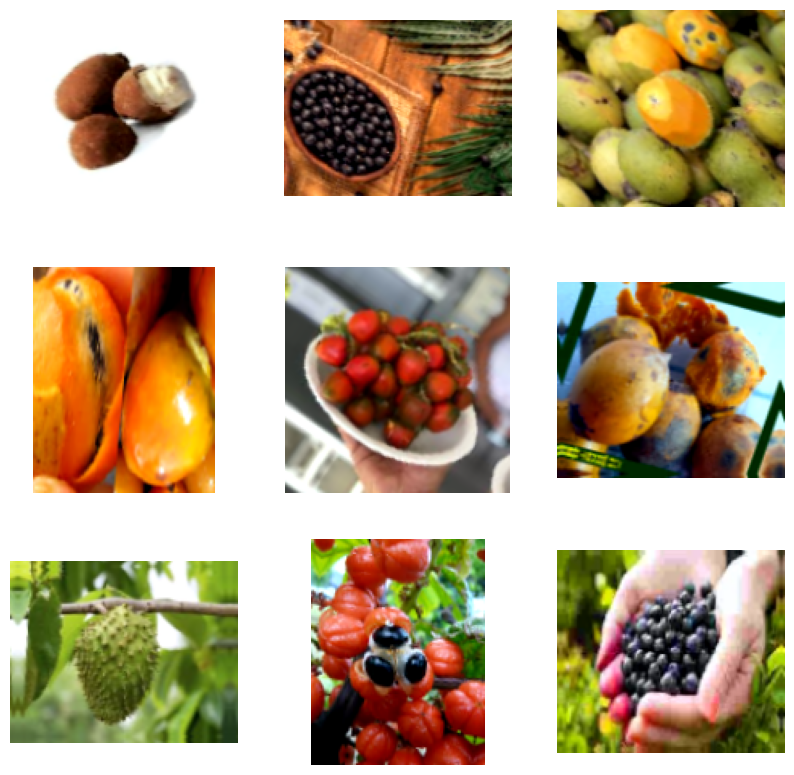

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define augmentation (simpler first)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomWidth(0.2),  # Stretch width
    layers.RandomHeight(0.2),  # Stretch height
    layers.RandomContrast(0.3),
])


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(tf.expand_dims(images[i], axis=0), training=True)
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(augmented[0], 0, 1).numpy())
        plt.axis("off")
plt.show()


# Finding image shape

In [ ]:
for image_batch, labels_batch in train_ds.take(1):  # Get one batch
    print(image_batch.shape)  # Prints (batch_size, height, width, channels)
    break

(32, 128, 128, 3)


In [ ]:
input_shape = (32, 128, 128, 3)

#Applying Batch Normalization

In [ ]:
from tensorflow.keras.layers import BatchNormalization
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

#Applying DropOut

In [ ]:
from tensorflow.keras.layers import Dropout
layer = Dropout(rate=0.25, noise_shape=None, seed=None)

#Implementing CNN Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = len(class_names)

# Define the model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), padding='same', activation=None, input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output of the last Conv2D layer
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),

    # Output Layer
    layers.Dense(10, activation='softmax')  # Assuming 10 classes
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,802 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

#Compilation and model fit

In [ ]:
inputs = keras.Input(shape=input_shape)

# Compile the model
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint_cb = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=8,
    epochs=2000,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2000
)

model.summary()

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1852 - loss: 9.4436 

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.1840 - loss: 10.8888 - val_accuracy: 0.8333 - val_loss: 3.6988
Epoch 2/2000
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1562 - loss: 83.7309

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.1476 - loss: 75.7724 - val_accuracy: 0.0000e+00 - val_loss: 2.2152
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.2166 - loss: 2.2455 - val_accuracy: 0.0000e+00 - val_loss: 2.3090
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1584 - loss: 2.1159 - val_accuracy: 0.0000e+00 - val_loss: 2.3646
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.1949 - loss: 2.2132 - val_accuracy: 0.0000e+00 - val_loss: 2.5275
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.1910 - loss: 2.1627 - val_accuracy: 0.0000e+00 - val_loss: 2.2818
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1654 - loss: 2.0098 - val_accuracy: 0.0000e+00 - val_loss: 2.2838
Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1957 - loss: 2.5015 - val_accuracy: 0.1111 - val_loss: 2.2998
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2873 - loss: 2.0390 - val_acc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,804 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

# Evaluating the model


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size= batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
  )

Found 30 files belonging to 6 classes.
Using 24 files for training.


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.4167 - loss: 1259.8942
Test Loss: 1259.8942
Test Accuracy: 0.4167


# Save and load the model

In [ ]:
# Save the model
model.save('trained_model.h5')

# Load the model
loaded_model = keras.models.load_model('trained_model.h5')

# Re-evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step - accuracy: 0.4167 - loss: 1259.8940
Test Loss: 1259.8940
Test Accuracy: 0.4167


# Predictions and Classification reports

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     guarana       0.50      0.50      0.50         4
     cupuacu       0.33      0.75      0.46         4
    graviola       0.50      0.25      0.33         4
        acai       0.50      1.00      0.67         3
     pupunha       0.33      0.20      0.25         5
      tucuma       0.00      0.00      0.00         4

    accuracy                           0.42        24
   macro avg       0.36      0.45      0.37        24
weighted avg       0.35      0.42      0.35        24



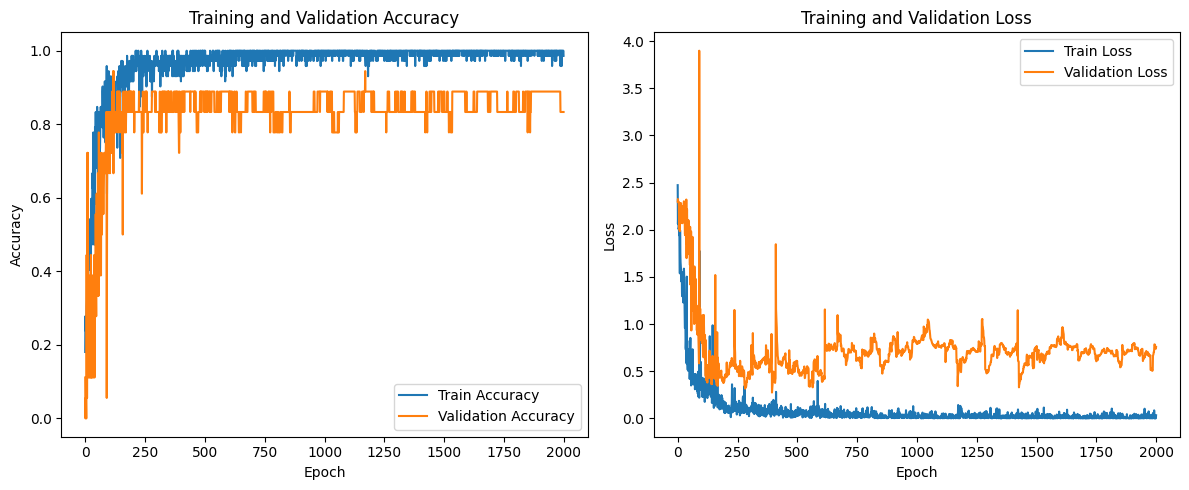

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = loaded_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

#TASK-02: Transfer Learning
To - Do:

• Implement transfer learning using a pre-trained model trained on ImageNet weights, freeze the
layers of the model, and fit it only on the output layer to classify the fruits dataset.


• Evaluate the model’s performance and generate an inference output and classification report.


• Did the performance improved compared to training from scratch.

In [ ]:
from tensorflow.keras.applications import VGG16

# Load VGG16 without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers so their weights won't change during training
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)           # Flatten the output
x = Dense(1024, activation='relu')(x)     # Fully connected layer
outputs = Dense(10, activation='softmax')(x)  # Output layer (10 classes)

# Create the full model
model = Model(inputs=base_model.input, outputs=outputs)


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Change to 'categorical_crossentropy' if needed
    metrics=['accuracy']
)


In [ ]:
# If using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=(224, 224),
    batch_size=32
)


Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1752 - loss: 7.6789   

3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 17s/step - accuracy: 0.1925 - loss: 7.5735 - val_accuracy: 0.5000 - val_loss: 5.2693
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 338ms/step - accuracy: 0.7082 - loss: 2.5080 - val_accuracy: 0.6667 - val_loss: 1.6142
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.9644 - loss: 0.3962 - val_accuracy: 0.6333 - val_loss: 2.4884
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.9165 - loss: 0.6140 - val_accuracy: 0.8000 - val_loss: 1.8623
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.9655 - loss: 0.3147 - val_accuracy: 0.8000 - val_loss: 1.3930
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8333 - val_loss: 1.3079
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.9716 - loss: 0.0413 - val_accuracy: 0.7333 - val_loss: 1.4048
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.9850 - loss: 0.0334 - val_accuracy: 0.7333 - val_loss: 1.5044
Epo

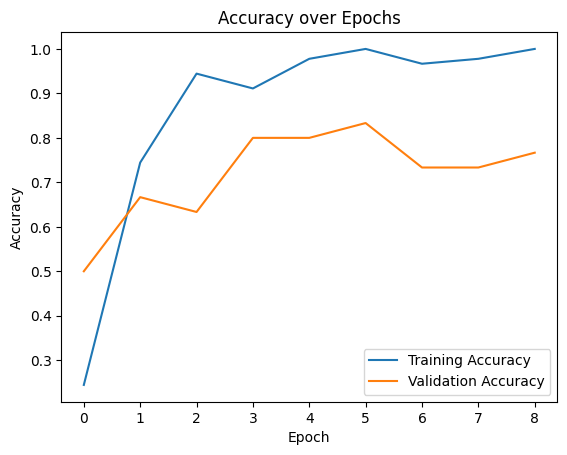

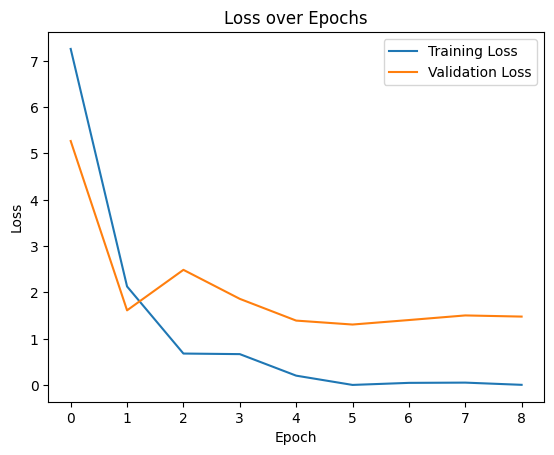

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
